## Physical Review B , 106, 035432 (2022)
Reproducing results presented in https://journals.aps.org/prb/pdf/10.1103/PhysRevB.106.035432

In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [265]:
from dataclasses import dataclass
@dataclass
class system_parameters:
    t : float # Hopping integral
    W: float # Width of normal region
    L: float # Length of normal region
    a : float # Lattice constant
    mu : float # Chemical potential
    Delta: float # SUperconducting gap.
    flux: float # Flux throught the normal region.
    phase: float  # Josephson phase difference. 

    ## Scanning Gate tip strength:
    V_0 : float # Effective magntidue of tip potential
    d : float # Width of scattering potential 
    y_tip: float # Positions of tip in junction.
    x_tip: float

params = system_parameters(t = 0.5 , W = 100 , L = 10 , a = 1, Delta = 1 , mu = 0.2, flux= 0.5 , phase = 0.5 , V_0 = 0 , 
                           x_tip = 75 , y_tip = 10 , d = 2)

# In my units e = h = 1. So Phi_0 , the elementary flux quantum (h/e) is 1 and the superconducting flux quantum Phi_S (h/2e) is 1/2. 
# Flux is given in units of the elementary flux quantum.

# Function for computing normal S-matrix. 
def compute_normal_s_matrix(params):
    B = params.flux/((params.W)*(params.L ))
    peierlphase = B*params.a*2*np.pi
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a , norbs = 1)

    def tip_potential(V_0 , d ,x , y, x_tip , y_tip):
        return V_0 / ( 1 + ((x - x_tip)**2  + (y - y_tip)**2)/(d**2))
    
    for i in range(int(params.W / params.a)):
        for j in range(int(params.L / params.a)):
            syst[lat(i , j)] = 4*params.t/(params.a**2) - params.mu + tip_potential(params.V_0 , params.d , i*params.a ,
                                                                                    j*params.a , params.x_tip , params.y_tip)
            if i > 0:
                syst[lat(i , j) , lat(i-1 , j)] = -params.t/(params.a**2)
            if j > 0:
                syst[lat(i , j) , lat(i , j-1)] = -params.t*np.exp(1j*(i*params.a)*peierlphase)/(params.a**2)

    
    # Construct normal leads, with no magnetic field to account for screening.
    lead = kwant.Builder(kwant.TranslationalSymmetry((0 , -params.a)))
    for i in range(int(params.W / params.a)):
        lead[lat(i , 0)] = 4*params.t - params.mu
        if i > 0:
            lead[lat(i , 0) , lat(i-1 , 0)] = -params.t
        lead[lat(i , 1) , lat(i , 0)] = -params.t
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    # Compute S-matrix of the normal region between leads. In the short junction regime , we can calcualte it at E = 0.
    s_matrix = kwant.smatrix(syst , 0)
    wf = kwant.wave_function(syst , energy = 0)
    return s_matrix , wf , syst

In [266]:
s_matrix_test , wf , syst = compute_normal_s_matrix(params)
lead_info = s_matrix_test.lead_info
num_propagating = s_matrix_test.num_propagating(1)
print(num_propagating)
len(lead_info[0].momenta)

20


40

In [267]:
(s_matrix_test.data).shape

(40, 40)

In [268]:
# Andreev reflection matrix:
def andreev(smatrix , params):
    # We need to know how many modes are in each lead:
    N = smatrix.num_propagating(0)
    M = smatrix.num_propagating(1)

    r_A00 = 1j*np.identity(N)
    r_A11 = 1j*np.exp(-1j*params.phase)*np.identity(M)
    r_A01 = np.zeros(shape = (N , M))
    r_A10 = np.zeros(shape = (M , N))
    r_A = np.block([[r_A00 , r_A01],[r_A10 , r_A11]])
    r_A_deriv = np.block([[np.zeros(shape = (N , N)) , r_A01],[r_A10 , -1j*r_A11]])
    return  r_A , r_A_deriv

# Compute Andreev bound states:
def compute_ABS(smatrix , params):
    r_A = andreev(smatrix , params)[0]
    s = smatrix.data
    #  Calculate A matrix:
    A = (-s.T @ r_A + r_A @ s)/2
    
    # Constructing matrix to diagonalise for energies:
    zeroes = np.zeros(shape = A.shape)
    matrix = np.block([[zeroes , -1j*np.conjugate(A.T)],[1j*A , zeroes]])
    evals , evecs = np.linalg.eigh(params.Delta*matrix)
    return evals , evecs

In [269]:
# Compute ABS in an alternative way:
def compute_ABS_alternative(smatrix , params):
    r_A = andreev(smatrix , params)[0]
    s= smatrix.data 

    # Constructing the X matrix:
    zeroes = np.zeros(shape = s.shape)
    X = np.block([[zeroes , np.conj(s.T)@np.conj(r_A)],[(s.T)@r_A , zeroes]])

    evals  , evecs = np.linalg.eig(X)
    return evals , evecs

In [270]:
# Compute critical currents:
def compute_I_c(flux_value , params , no_phases = 101):
    # Values for superconducting phase
    phases = np.linspace(0 , 2*np.pi , no_phases)
    params.flux = flux_value
    pos_evals = []
    for phase in phases:
        params.phase = phase
        smatrix = compute_normal_s_matrix(params)[0]
        evals , evecs = compute_ABS(smatrix , params)
        # Extract positive evals:
        pos_evals.append(evals[evals > 0])
    pos_evals = np.stack(pos_evals , axis = 1)
    # Sum up all the positive eigenenergies for each pahse value:
    summed = np.sum(pos_evals , axis = 0)
    # Current is gradient of all of the positive eigeneneries:
    current = np.gradient(summed , phases)
    I_c = np.max(current)
    return I_c , [phases , current]

In [342]:
def calculate_supercurrent_distribution(flux_value , phase , params):
    # Calculate supercurrent distribution in junction from ABS amplitudes:

    # Overwrite parameters flux and phase:
    params.flux = flux_value
    params.phase = phase
    
    smatrix , wf , syst = compute_normal_s_matrix(params)
    evals , evecs = compute_ABS(smatrix , params)

    # Extract eigenvectors that correspond to positive energy ABS:
    evecs_pos = evecs[: , evals> 0]
    electron_vectors = evecs_pos[ 0 : int(evecs_pos.shape[0]/2) , :]
    hole_vectors = evecs_pos[ int(evecs_pos.shape[0]/2):  ,  :   ]

    # Zero energy scattering wavefunctions:
    psi_wf = np.vstack((wf(0) , wf(1)))


    print(hole_vectors.shape)
    print(psi_wf.shape)
    # Electron amplitudes:
    A_e = np.conj(electron_vectors) @ psi_wf
    # Hole_amplitudes:
    A_h = np.conj(hole_vectors) @ psi_wf

    # Probablitity current operator:
    J = kwant.operator.Current(syst , 1)

    # Charge amplitude:
    total_current = 0
    # COmputing difference between electron and hole currents for each positive energy eigenstate:
    for i in range(A_e.shape[0]):
        J_e = -J(A_e[i , :])
        J_h = J(A_h[i , :])

        total_current += J_e + J_h
    
    kwant.plotter.current(syst , total_current);
    return total_current , A_e , A_h , psi_wf

(40, 40)
(40, 1000)


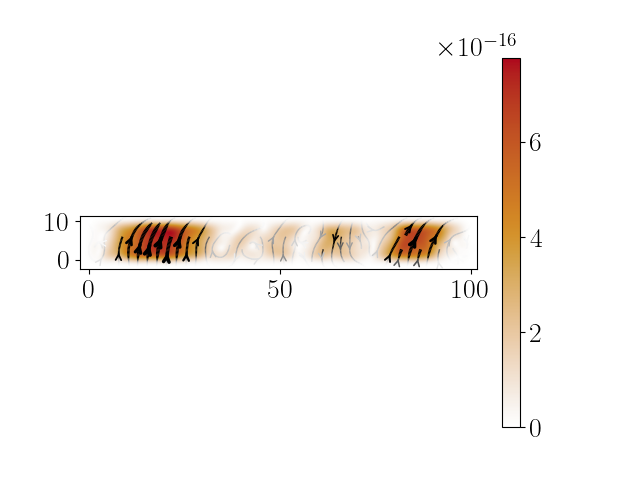

In [344]:
t_c , A_e , A_h , psi_wf = calculate_supercurrent_distribution(5 , 0, params)

### Code that takes a while:

In [313]:
I_c_test , [phases_test , currents_test] = compute_I_c(0.0 , params , no_phases = 201)

In [287]:
from tqdm import tqdm
fluxes = np.linspace(-2 , 2 , 81)
I_c_values = np.zeros(len(fluxes))
CPRS = []
for i in tqdm(range(len(fluxes))):
    I_c_values[i] , current_phase_relation = compute_I_c(fluxes[i] , params , no_phases = 101)
    CPRS.append(current_phase_relation)

100%|██████████| 81/81 [35:43<00:00, 26.46s/it]


(0.0, 20.950289273032134)

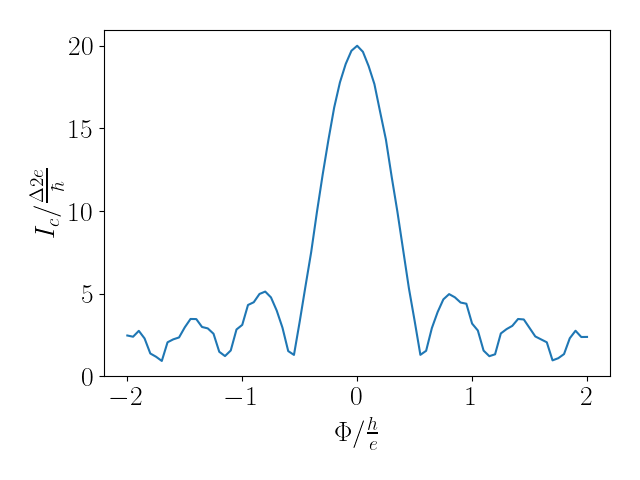

In [297]:
plt.figure()
plt.plot(fluxes , I_c_values / params.Delta)
plt.xlabel(r'$\Phi / \frac{h}{e}$')
plt.ylabel(r'$I_{c} / \frac{\Delta 2e}{\hbar}$')
plt.tight_layout()
plt.ylim(bottom = 0)

In [301]:
import pickle
import os 
from datetime import datetime
date_time = datetime.today().strftime('%Y_%m_%d_%H_%M')
currentworkingdirectory = os.getcwd() + '/notip_' + date_time + '.pkl'
pickle_dict = {'params' : params , 'I_c_values' : I_c_values , 'CPRS': CPRS}
with open( currentworkingdirectory,  'wb') as f:
    pickle.dump(pickle_dict , f)